In [1]:
# common stats analysis stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
import pingouin as pg

#scikit learn
from sklearn.linear_model import LogisticRegression

# formulat interface to statsmodels (standard linear models)
import statsmodels.api as sm
import statsmodels.formula.api as smf
# BAyesian Model-building Interface (BAMBI)
import bambi as bmb
import arviz as az

# for printing pretty tables and plots
from tabulate import tabulate
from  matplotlib.ticker import FuncFormatter, MaxNLocator

# some stuff for making notebooks look nice
from IPython.core.display import HTML, Markdown, display

# seed RNG
np.random.seed(0)

# hate these things
import warnings
warnings.filterwarnings("ignore")

# display all columns of dataframes
pd.set_option('display.max_columns', None)

# display x rows of dataframes
pd.set_option('display.max_rows', 30) # set to None to show all rows

#median for rts 
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }
# import the data
exp_df = pd.read_csv("cleandata/exp-08-02-2022.csv")
qdf = pd.read_csv("cleandata/q-08-02-2022.csv")

/anaconda/envs/shj-exp/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
/anaconda/envs/shj-exp/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
/anaconda/envs/shj-exp/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [39]:
# add some helpful columns to the df
# make sure the columns are coded as their proper data types
# 

df = exp_df.loc[:,~exp_df.columns.str.match("Unnamed")]

df["ruleInt"]=df["ruleInt"].astype("Int64")
df["ruleStr"]=df["ruleInt"].replace({1:"I",2:"II", 3:"III", 4:"IV", 5:"V", 6:"VI"})
df["ruleStr"]=df["ruleStr"].astype("category")
# df["hit"] = df["hitormiss"].astype(int)
df["hitStr"]=df["hitormiss"].replace({False:"0",True:"1"}).astype("category")
df["subjid"]=df["subjid"].astype("category")
df["game"]=df["game"].astype("Int64")
df["trial"]=df["trial"].astype("Int64")

testdf = df.loc[(df["phase"]=="test")]
learndf = df.loc[(df["phase"]=="learn")]
taskdf = df.loc[(df["phase"]=="task")]

display(df.head())

,phase,subjid,incentive,rule,dimorder,dimvals,condition,counterbalance,block,trial,nrepeats,theorystim,actualstim,correct,resp,hitormiss,rt,testscore,timestop,lasttwodigits,bonusprob,bonus,ruleInt,ruleStr,expNum,iid,answervalue,game,ticketvalue,ticketcolor,blocktrial,bonustodate,totalbonustodate,ntrials,points,allcards,moreA,scoretodate,score,bonusvalue,win,hitStr
0,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,1,2.0,6.0,5.0,0.0,0.0,True,3589.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,2,2.0,4.0,7.0,1.0,0.0,False,10256.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,3,2.0,7.0,4.0,0.0,0.0,True,11863.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,4,2.0,7.0,4.0,0.0,0.0,True,5234.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,5,2.0,5.0,6.0,0.0,1.0,False,4442.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Mixed logistic regression

### Experiment 1

In [3]:
# experiment 1 (0)
testdata0 = testdf.loc[testdf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata0 = learndf.loc[learndf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

testdata0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 16 to 10449
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   subjid     3344 non-null   category
 1   trial      3344 non-null   Int64   
 2   ruleStr    3344 non-null   category
 3   incentive  3344 non-null   float64 
 4   hitStr     3344 non-null   category
 5   rt         3344 non-null   float64 
dtypes: Int64(1), category(3), float64(2)
memory usage: 140.6 KB


In [4]:
# ------- performance by rule
print("Performance by rule and incentive (no interaction)")

model0 = bmb.Model('hitStr["1"] ~ ruleStr + incentive', testdata0, family="bernoulli")
print(model0)
results0 = model0.fit(draws=1000, chains=4)
az.summary(results0)

Performance by rule and incentive (no interaction)
Formula: hitStr["1"] ~ ruleStr + incentive
Family name: Bernoulli
Link: logit
Observations: 3344
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.9076)
    ruleStr ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [6.5848 6.9877 6.5848 7.1302 6.417 ])
    incentive ~ Normal(mu: 0.0, sigma: 0.2078)


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.489,0.174,2.184,2.828,0.005,0.003,1300.0,1789.0,1.0
ruleStr[II],-1.233,0.188,-1.586,-0.889,0.005,0.004,1400.0,2070.0,1.0
ruleStr[III],-1.550,0.191,-1.887,-1.180,0.005,0.004,1419.0,2167.0,1.0
ruleStr[IV],-1.184,0.190,-1.522,-0.815,0.005,0.004,1427.0,2001.0,1.0
ruleStr[V],-1.194,0.193,-1.552,-0.830,0.005,0.004,1416.0,2113.0,1.0
ruleStr[VI],-1.810,0.185,-2.149,-1.467,0.005,0.004,1302.0,1955.0,1.0
incentive,-0.002,0.003,-0.009,0.005,0.000,0.000,3005.0,2610.0,1.0


In [5]:
# ------- performance by incentive and rule WITH interaction
model0interaction = bmb.Model('hitStr["1"] ~ ruleStr*incentive', testdata0, family="bernoulli")
print(model0interaction)
results0interaction = model0interaction.fit(draws=1000, chains=4)
az.summary(results0interaction)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr*incentive
Family name: Bernoulli
Link: logit
Observations: 3344
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5.2774)
    ruleStr ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [6.5848 6.9877 6.5848 7.1302 6.417 ])
    incentive ~ Normal(mu: 0.0, sigma: 0.2078)
    ruleStr:incentive ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [0.3159 0.3275 0.3099 0.3419 0.3235])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive, ruleStr:incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.221,0.253,1.766,2.711,0.009,0.007,726.0,1322.0,1.0
ruleStr[II],-0.837,0.308,-1.412,-0.251,0.010,0.007,890.0,1681.0,1.0
ruleStr[III],-1.122,0.310,-1.676,-0.535,0.010,0.007,956.0,1735.0,1.0
ruleStr[IV],-0.784,0.309,-1.375,-0.206,0.011,0.008,837.0,1627.0,1.0
ruleStr[V],-1.070,0.304,-1.681,-0.539,0.010,0.007,896.0,1645.0,1.0
ruleStr[VI],-1.619,0.290,-2.156,-1.056,0.010,0.007,832.0,1581.0,1.0
incentive,0.015,0.013,-0.009,0.039,0.000,0.000,793.0,1429.0,1.0
ruleStr:incentive[II],-0.025,0.015,-0.053,0.004,0.000,0.000,959.0,1590.0,1.0
ruleStr:incentive[III],-0.026,0.015,-0.054,0.003,0.000,0.000,1078.0,1734.0,1.0
ruleStr:incentive[IV],-0.025,0.015,-0.052,0.005,0.001,0.000,921.0,1642.0,1.0


In [6]:
# ------- response time
print("Response time by incentive")

model0rt_test = bmb.Model('rt ~ incentive + ruleStr', testdata0)
results0rt_test = model0rt_test.fit(draws=1000, chains=4)
az.summary(results0rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,1759.840,224.765,1331.055,2178.735,5.110,3.627,1933.0,2443.0,1.0,1760.710,155.765
incentive,-0.356,6.470,-12.682,11.674,0.095,0.097,4684.0,3212.0,1.0,-0.411,4.322
ruleStr[II],770.267,273.567,255.561,1280.600,5.964,4.218,2105.0,2871.0,1.0,765.235,189.558
ruleStr[III],1144.649,282.337,625.181,1679.960,5.998,4.242,2214.0,2650.0,1.0,1148.144,186.556
ruleStr[IV],1299.341,269.728,805.398,1810.518,6.010,4.250,2018.0,3142.0,1.0,1306.517,181.516
ruleStr[V],1566.484,282.113,1064.164,2115.067,6.138,4.340,2122.0,3103.0,1.0,1569.132,191.511
ruleStr[VI],1330.101,264.120,865.600,1859.990,5.773,4.083,2095.0,3194.0,1.0,1331.517,184.447
rt_sigma,4578.590,54.931,4477.509,4683.556,0.819,0.579,4487.0,3041.0,1.0,4578.532,37.642


In [7]:
print("LEARNING phase response time data")
model0rt_learn = bmb.Model('rt ~ incentive + ruleStr', learndata0)
results0rt_learn = model0rt_learn.fit(draws=1000, chains=4)
az.summary(results0rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,2912.297,694.370,1602.601,4163.726,16.177,11.519,1843.0,2414.0,1.0,2928.711,468.234
incentive,-19.616,19.554,-56.938,16.178,0.338,0.258,3323.0,3341.0,1.0,-19.183,12.993
ruleStr[II],946.133,827.219,-452.557,2670.596,18.931,13.389,1917.0,2489.0,1.0,923.606,556.518
ruleStr[III],2295.041,861.914,722.831,3955.936,19.355,13.688,1983.0,2806.0,1.0,2300.291,575.430
ruleStr[IV],988.847,840.240,-584.183,2549.616,18.885,13.356,1980.0,2677.0,1.0,970.881,563.255
ruleStr[V],2795.100,867.357,1301.903,4615.790,18.932,13.448,2100.0,2723.0,1.0,2797.821,586.884
ruleStr[VI],1457.433,824.078,-202.514,2886.525,19.195,13.575,1843.0,2461.0,1.0,1455.298,577.937
rt_sigma,19467.223,167.711,19131.308,19767.776,2.702,1.911,3865.0,3171.0,1.0,19466.359,112.741


### Experiment 2

In [8]:
# experiment 2
print("EXPERIMENT 2")

# experiment 2 (1)
testdata1 = testdf.loc[testdf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata1 = learndf.loc[learndf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model1 = bmb.Model('hitStr["1"] ~ ruleStr + incentive', testdata1, family="bernoulli")
print(model1)
results1 = model1.fit(draws=1000, chains=4)
az.summary(results1)



Modeling the probability that hitStr==1


EXPERIMENT 2
Formula: hitStr["1"] ~ ruleStr + incentive
Family name: Bernoulli
Link: logit
Observations: 778
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.5621)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0003)
    incentive ~ Normal(mu: 0.0, sigma: 0.1667)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.886,0.187,1.518,2.214,0.003,0.002,4940.0,2950.0,1.0
ruleStr[IV],0.476,0.208,0.092,0.866,0.003,0.002,5107.0,2920.0,1.0
incentive,-0.020,0.007,-0.033,-0.007,0.000,0.000,4693.0,3143.0,1.0


In [9]:
# ------- reaction time
print("Response time by incentive")

model1rt_test = bmb.Model('rt ~ incentive + ruleStr', testdata1)
results1rt_test = model1rt_test.fit(draws=1000, chains=4)
az.summary(results1rt_test, stat_funcs=func_dict, extend=True)


Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,2438.678,236.332,1994.667,2876.072,2.754,2.014,7371.0,3287.0,1.0,2443.612,162.489
incentive,14.751,9.407,-2.346,32.309,0.112,0.094,7107.0,3260.0,1.0,14.694,6.309
ruleStr[IV],-83.184,267.817,-595.576,402.871,3.437,4.216,6067.0,3139.0,1.0,-81.353,181.272
rt_sigma,3728.758,94.248,3551.893,3902.209,1.230,0.871,5871.0,2958.0,1.0,3726.944,64.801


In [10]:
print("LEARNING phase response time data")
model1rt_learn = bmb.Model('rt ~ incentive + ruleStr', learndata1)
results1rt_learn = model1rt_learn.fit(draws=1000, chains=4)
az.summary(results1rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,3233.502,255.041,2770.226,3726.458,3.187,2.277,6376.0,2829.0,1.0,3235.095,169.155
incentive,19.035,9.635,-0.182,35.931,0.119,0.092,6513.0,3199.0,1.0,19.050,6.645
ruleStr[IV],-616.802,284.970,-1148.835,-88.071,3.523,2.695,6543.0,3296.0,1.0,-621.863,195.993
rt_sigma,7988.829,102.714,7806.041,8187.714,1.281,0.906,6394.0,2627.0,1.0,7989.548,68.483


### Experiment 3

In [11]:
# experiment 3

# experiment 3 (2)
testdata2 = testdf.loc[testdf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata2 = learndf.loc[learndf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model2 = bmb.Model('hitStr["1"] ~ ruleStr + incentive', testdata2, family="bernoulli")
print(model2)
results2 = model2.fit(draws=1000, chains=4)
az.summary(results2)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr + incentive
Family name: Bernoulli
Link: logit
Observations: 744
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.5873)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0072)
    incentive ~ Normal(mu: 0.0, sigma: 0.1671)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.912,0.192,1.545,2.266,0.003,0.002,5289.0,3120.0,1.0
ruleStr[IV],-0.459,0.194,-0.833,-0.111,0.003,0.002,5050.0,2565.0,1.0
incentive,-0.007,0.007,-0.019,0.005,0.000,0.000,5308.0,2894.0,1.0


In [12]:
# ------- reaction time
print("Response time by incentive")

model2rt_test = bmb.Model('rt ~ incentive + ruleStr', testdata2)
results2rt_test = model2rt_test.fit(draws=1000, chains=4)
az.summary(results2rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,3294.088,330.657,2675.270,3915.568,4.090,2.912,6548.0,3534.0,1.0,3300.804,220.745
incentive,13.917,12.254,-8.098,37.621,0.155,0.155,6236.0,2966.0,1.0,13.882,8.169
ruleStr[IV],-757.757,368.347,-1454.505,-103.909,4.711,3.504,6138.0,3315.0,1.0,-759.848,253.627
rt_sigma,4926.055,130.698,4690.848,5176.487,1.708,1.209,5832.0,3151.0,1.0,4923.170,90.639


In [13]:
print("LEARNING phase response time data")
model2rt_learn = bmb.Model('rt ~ incentive + ruleStr', learndata2)
results2rt_learn = model2rt_learn.fit(draws=1000, chains=4)
az.summary(results2rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took -188 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,4194.753,295.412,3638.523,4743.539,3.588,2.558,6765.0,3069.0,1.0,4194.591,203.714
incentive,8.058,10.886,-11.709,28.898,0.128,0.138,7243.0,3408.0,1.0,7.969,7.412
ruleStr[IV],-870.904,316.460,-1450.949,-280.650,4.023,2.963,6162.0,3275.0,1.0,-870.968,220.779
rt_sigma,8683.946,113.717,8474.609,8897.113,1.433,1.014,6267.0,3232.0,1.0,8683.035,78.582


### Experiment 4

WITHIN SUBJECTS. Each subj performs 4 blocks. Low vs High incentive crossed with Rule type II and IV.

TODO: This regression needs to consider the subject-level data accounting for the within design

In [14]:
# experiment 4
# WITHIN SUBJECTS, so data frame looks a little different - each subject does 4 blocks

# experiment 4 (3)
testdata3 = testdf.loc[testdf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata3 = learndf.loc[learndf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model3 = bmb.Model('hitStr["1"] ~ ruleStr + ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', testdata3, family="bernoulli")
print(model3)
results3 = model3.fit(draws=1000, chains=4)
az.summary(results3)


Formula: hitStr["1"] ~ ruleStr + ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 992
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3784)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0)
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.3784))
    ruleStr|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.0))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.995,0.418,1.222,2.780,0.018,0.013,534.0,1160.0,1.01
ruleStr[IV],-0.191,0.279,-0.725,0.343,0.008,0.006,1203.0,1351.0,1.00
ticketvalue,-0.017,0.155,-0.308,0.270,0.003,0.003,2856.0,2431.0,1.00
1|subjid_sigma,1.885,0.382,1.195,2.584,0.014,0.010,775.0,1638.0,1.00
ruleStr|subjid_sigma[IV],1.042,0.304,0.524,1.634,0.009,0.006,1151.0,1723.0,1.00
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],-0.064,0.265,-0.638,0.408,0.005,0.004,2903.0,2274.0,1.00
ticketvalue|subjid[31],0.086,0.248,-0.365,0.608,0.006,0.005,2465.0,1613.0,1.00
ticketvalue|subjid[32],0.031,0.279,-0.485,0.592,0.008,0.008,2252.0,1377.0,1.00
ticketvalue|subjid[34],0.035,0.265,-0.494,0.591,0.005,0.004,3335.0,2454.0,1.00


In [15]:
# # ------- performance by game
# print(testdata3["game"].unique())
# model3game = bmb.Model('hitStr["1"] ~ game + (game|subjid)', testdata3, family="bernoulli")
# print(model3game)
# results3game = model3game.fit(draws=1000, chains=4)
# az.summary(results3game)


In [16]:
# ------- reaction time
print("Response time by incentive")

model3rt_test = bmb.Model('rt ~ ruleStr + ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', testdata3)
results3rt_test = model3rt_test.fit(draws=1000, chains=4)
az.summary(results3rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,4813.486,1063.358,3013.964,7045.889,17.390,12.472,3741.0,2394.0,1.0,4794.756,698.532
ruleStr[IV],-1364.143,1108.399,-3340.972,825.483,16.540,15.163,4440.0,2437.0,1.0,-1385.534,752.277
ticketvalue,-401.826,925.911,-2147.580,1280.175,13.418,14.088,4755.0,2768.0,1.0,-424.021,629.577
1|subjid_sigma,2531.172,979.852,637.523,4370.536,31.489,22.273,975.0,1003.0,1.0,2552.102,632.348
ruleStr|subjid_sigma[IV],972.064,738.730,6.049,2327.705,16.641,11.768,1908.0,2270.0,1.0,818.628,488.717
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],-76.052,1131.287,-2472.989,2078.205,19.779,16.156,3572.0,2470.0,1.0,-6.897,466.438
ticketvalue|subjid[31],-143.863,1127.340,-2637.265,1954.841,17.916,16.235,4217.0,2710.0,1.0,-36.945,470.050
ticketvalue|subjid[32],74.216,1139.690,-2031.846,2522.498,19.982,18.520,3732.0,2716.0,1.0,14.826,435.154
ticketvalue|subjid[34],-25.609,1103.905,-2101.267,2391.411,20.363,17.443,3299.0,2303.0,1.0,-12.928,447.658


In [17]:
# ------- reaction time
print("Response time in learning phase")

model3rt_learn = bmb.Model('rt ~ ruleStr + ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', learndata3)
results3rt_learn = model3rt_learn.fit(draws=1000, chains=4)
az.summary(results3rt_learn, stat_funcs=func_dict, extend=True)

Response time in learning phase


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,5023.529,1021.869,3097.268,6924.500,29.482,20.852,1209.0,1871.0,1.01,5010.272,690.246
ruleStr[IV],-1049.275,890.152,-2597.501,646.704,21.454,19.031,1744.0,1443.0,1.00,-1035.466,612.543
ticketvalue,-1103.690,815.413,-2639.163,368.020,30.619,21.660,742.0,419.0,1.01,-1112.049,542.724
1|subjid_sigma,3720.234,882.527,2189.309,5403.549,45.362,36.072,491.0,240.0,1.01,3628.327,571.212
ruleStr|subjid_sigma[IV],745.274,563.214,2.241,1748.456,13.135,9.289,1622.0,1634.0,1.00,643.936,357.078
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],79.353,1260.340,-2510.179,2680.417,38.818,30.241,1251.0,1049.0,1.01,31.801,523.525
ticketvalue|subjid[31],-75.159,1377.943,-3183.639,2328.945,43.722,38.048,1179.0,967.0,1.01,-12.495,532.347
ticketvalue|subjid[32],421.923,1356.539,-2358.504,3184.183,50.610,37.795,929.0,798.0,1.00,173.070,561.074
ticketvalue|subjid[34],-365.078,1401.960,-3069.545,2436.318,66.875,67.950,797.0,443.0,1.02,-109.176,540.341


### Experiment 5

category recognition task (no discovery)
once again, incentive is varied within subject

In [18]:
# experiment 5 (4)
taskdata4 = taskdf.loc[taskdf["expNum"]==4][["subjid","trial","ruleStr","points","hitStr","rt"]]
# learndata4 = learndf.loc[learndf["expNum"]==4][["subjid","trial","ruleStr","ticketvalue","hitStr","rt"]]

taskdata4.head()


,subjid,trial,ruleStr,points,hitStr,rt
23329,0,0,I,16.0,1,26054.0
23330,0,1,I,2.0,1,20040.0
23331,0,2,I,1.0,1,15873.0
23332,0,3,I,2.0,1,21300.0
23333,0,4,I,4.0,1,15639.0


In [19]:
# ------- performance by incentive
model4 = bmb.Model('hitStr["1"] ~ ruleStr + points + (points|subjid)', taskdata4, family="bernoulli")
print(model4)
results4 = model4.fit(draws=1000, chains=4)
az.summary(results4)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr + points + (points|subjid)
Family name: Bernoulli
Link: logit
Observations: 8000
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.8933)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3167 5.3167])
    points ~ Normal(mu: 0.0, sigma: 0.3317)

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 3.8933))
    points|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3317))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, points, 1|subjid_sigma, 1|subjid_offset, points|subjid_sigma, points|subjid_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 251 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.440,0.182,1.091,1.770,0.011,0.008,287.0,743.0,1.02
ruleStr[II],-0.344,0.264,-0.865,0.108,0.018,0.012,224.0,455.0,1.02
ruleStr[IV],-0.678,0.250,-1.102,-0.172,0.015,0.010,298.0,526.0,1.01
points,0.024,0.005,0.015,0.033,0.000,0.000,612.0,657.0,1.01
1|subjid_sigma,1.363,0.094,1.198,1.553,0.005,0.003,461.0,801.0,1.01
...,...,...,...,...,...,...,...,...,...
points|subjid[204],0.002,0.021,-0.035,0.049,0.001,0.001,1304.0,967.0,1.01
points|subjid[205],0.011,0.022,-0.032,0.054,0.001,0.001,1176.0,1150.0,1.00
points|subjid[206],0.001,0.020,-0.039,0.038,0.000,0.000,1720.0,1334.0,1.00
points|subjid[207],-0.002,0.021,-0.042,0.040,0.000,0.000,1913.0,1578.0,1.00


In [20]:
# ------- reaction time
print("Response time by incentive")

model4rt = bmb.Model('rt ~ ruleStr + points + (points|subjid)', taskdata4)
results4rt = model4rt.fit(draws=1000, chains=4)
az.summary(results4rt, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, points, 1|subjid_sigma, 1|subjid_offset, points|subjid_sigma, points|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5818, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,10703.735,1797.440,7522.538,14094.503,124.249,89.572,217.0,502.0,1.01,10596.828,1249.988
ruleStr[II],5798.265,2611.029,1135.652,10740.235,356.946,269.425,55.0,265.0,1.06,5831.434,1833.461
ruleStr[IV],9288.496,2486.024,4413.429,13738.299,134.144,94.935,340.0,1068.0,1.01,9377.871,1677.112
points,291.641,51.420,196.778,391.134,4.752,3.411,118.0,289.0,1.03,292.312,35.018
1|subjid_sigma,13865.610,818.869,12388.253,15409.813,39.953,28.271,419.0,624.0,1.01,13841.878,529.668
...,...,...,...,...,...,...,...,...,...,...,...
points|subjid[204],-27.556,170.532,-378.930,281.195,12.587,9.157,247.0,132.0,1.03,-9.663,72.117
points|subjid[205],7.995,170.248,-363.864,342.092,11.117,7.871,269.0,203.0,1.02,4.956,74.410
points|subjid[206],-27.012,161.595,-381.546,272.904,9.938,7.035,288.0,283.0,1.02,-11.069,73.435
points|subjid[207],-27.534,164.785,-353.348,299.647,9.980,7.064,300.0,561.0,1.02,-11.280,78.600


EXPERIMENT 6

In [50]:
# EXPERIMENT 6 (5)

testdata5 = testdf.loc[testdf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata5 = learndf.loc[learndf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model5a = bmb.Model('hitStr["1"] ~ ruleStr + ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5a)
results5a = model5a.fit(draws=1000, chains=4)
az.summary(results5a)

Formula: hitStr["1"] ~ ruleStr + ticketvalue + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 10176
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3488)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3033 5.3844])
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.3488))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 558 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.846,0.306,4.273,5.410,0.010,0.007,959.0,1758.0,1.00
ruleStr[II],-2.303,0.367,-2.995,-1.648,0.015,0.010,630.0,1221.0,1.00
ruleStr[IV],-1.948,0.372,-2.673,-1.258,0.015,0.010,635.0,904.0,1.01
ticketvalue,0.337,0.107,0.136,0.535,0.003,0.002,1241.0,2077.0,1.01
1|subjid_sigma,2.038,0.145,1.767,2.306,0.005,0.003,931.0,1778.0,1.01
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-0.161,0.505,-1.125,0.776,0.009,0.007,3311.0,3025.0,1.00
ticketvalue|subjid[375],0.972,0.750,-0.416,2.355,0.011,0.009,4386.0,2907.0,1.00
ticketvalue|subjid[376],0.159,0.713,-1.191,1.509,0.011,0.010,3961.0,2999.0,1.00
ticketvalue|subjid[378],-0.365,0.516,-1.338,0.612,0.009,0.007,3441.0,2939.0,1.00


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'ruleStr\nII'}>,
       <AxesSubplot:title={'center':'ruleStr\nIV'}>,
       <AxesSubplot:title={'center':'ticketvalue'}>], dtype=object)

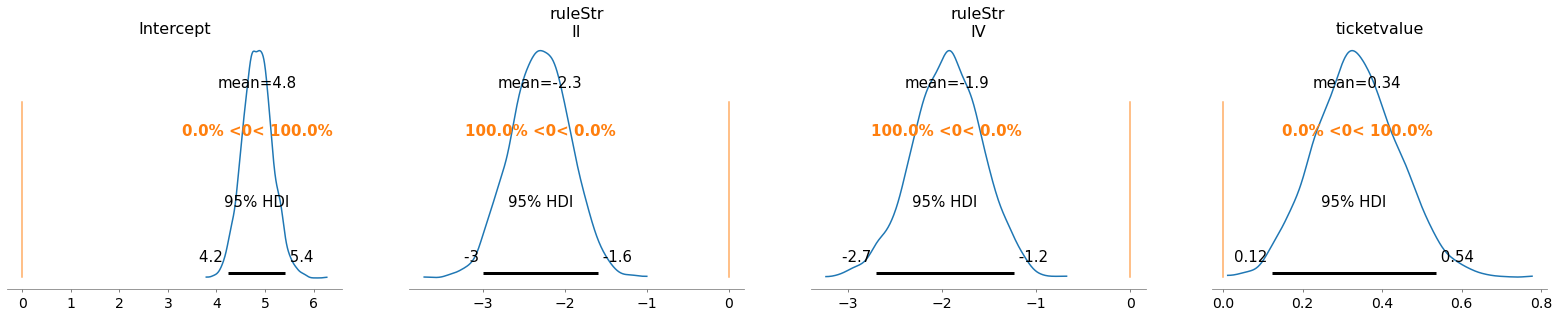

In [55]:
az.plot_posterior(results5a, var_names=["Intercept","ruleStr","ticketvalue"], hdi_prob=0.95, ref_val=0)

In [25]:

# ------- performance by incentive
model5 = bmb.Model('hitStr["1"] ~ ruleStr*ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5)
results5 = model5.fit(draws=1000, chains=4)
az.summary(results5)


Formula: hitStr["1"] ~ ruleStr*ticketvalue + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 10176
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.6284)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3033 5.3844])
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)
    ruleStr:ticketvalue ~ Normal(mu: [0. 0.], sigma: [5.4709 5.5998])

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.6284))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 390 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.943,0.314,4.355,5.534,0.006,0.004,2467.0,3217.0,1.0
ruleStr[II],-2.420,0.375,-3.128,-1.718,0.010,0.007,1511.0,2416.0,1.0
ruleStr[IV],-2.063,0.372,-2.742,-1.353,0.008,0.006,1919.0,2533.0,1.0
ticketvalue,0.146,0.243,-0.299,0.605,0.005,0.004,2739.0,2213.0,1.0
ruleStr:ticketvalue[II],0.241,0.272,-0.267,0.750,0.005,0.004,3063.0,2745.0,1.0
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-0.208,0.522,-1.205,0.736,0.007,0.008,6101.0,3045.0,1.0
ticketvalue|subjid[375],0.948,0.752,-0.464,2.364,0.010,0.009,5858.0,3278.0,1.0
ticketvalue|subjid[376],0.144,0.735,-1.150,1.584,0.009,0.011,6253.0,3379.0,1.0
ticketvalue|subjid[378],-0.376,0.534,-1.452,0.576,0.006,0.007,6998.0,3177.0,1.0


array([[<AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>,
        <AxesSubplot:title={'center':'ticketvalue'}>],
       [<AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>,
        <AxesSubplot:>]], dtype=object)

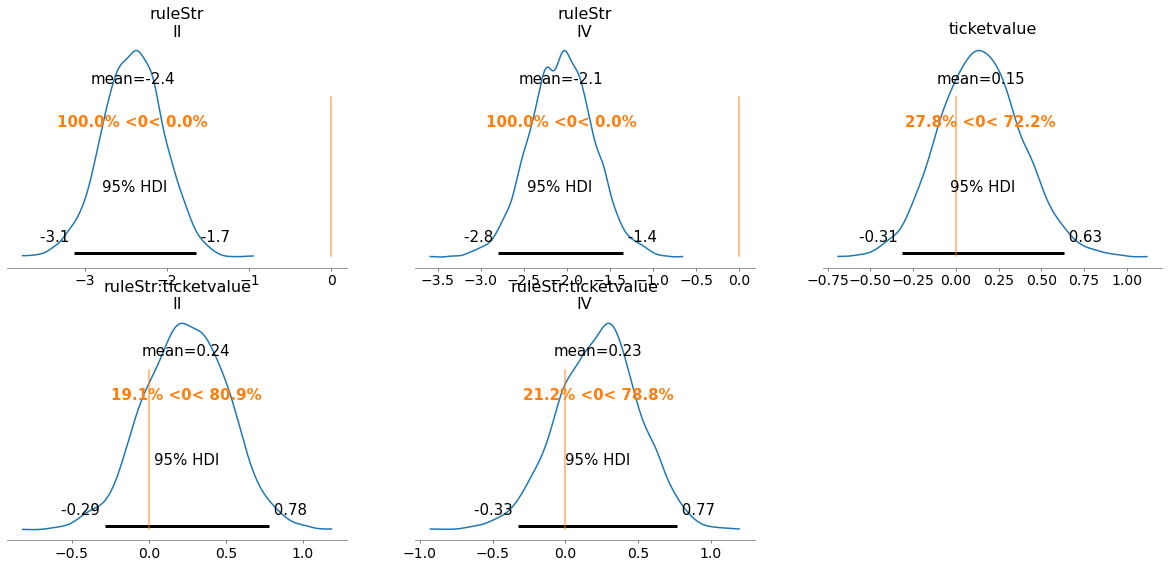

In [49]:
az.plot_posterior(results5, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [31]:
# ------- reaction time
print("Response time by incentive")

model5rt_test = bmb.Model('rt ~ ruleStr + ticketvalue + (ticketvalue|subjid)', testdata5)
results5rt_test = model5rt_test.fit(draws=1000, chains=4)
az.summary(results5rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,1645.236,323.543,1077.708,2278.969,5.246,3.780,3818.0,2862.0,1.0,1637.921,220.371
ruleStr[II],1253.899,427.421,450.807,2040.629,7.179,5.298,3566.0,3016.0,1.0,1246.796,287.019
ruleStr[IV],1524.702,441.631,728.079,2360.874,7.666,5.421,3329.0,2422.0,1.0,1528.582,300.068
ticketvalue,422.842,315.068,-166.235,1020.566,5.522,4.248,3253.0,2720.0,1.0,417.451,215.328
1|subjid_sigma,220.696,165.544,0.109,517.220,4.233,3.111,1485.0,1910.0,1.0,189.110,111.072
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-36.483,2233.623,-4384.593,4032.437,30.641,40.528,5306.0,2365.0,1.0,-31.870,1568.861
ticketvalue|subjid[375],-246.870,2250.143,-4182.454,4057.356,33.127,39.785,4679.0,2527.0,1.0,-258.337,1547.822
ticketvalue|subjid[376],-883.094,2262.662,-5062.450,3442.204,34.390,43.202,4345.0,1997.0,1.0,-854.775,1529.094
ticketvalue|subjid[378],-1253.505,2292.253,-5459.754,2990.676,32.867,37.411,4872.0,2294.0,1.0,-1247.985,1551.599


array([<AxesSubplot:title={'center':'ruleStr\nII'}>,
       <AxesSubplot:title={'center':'ruleStr\nIV'}>,
       <AxesSubplot:title={'center':'ticketvalue'}>], dtype=object)

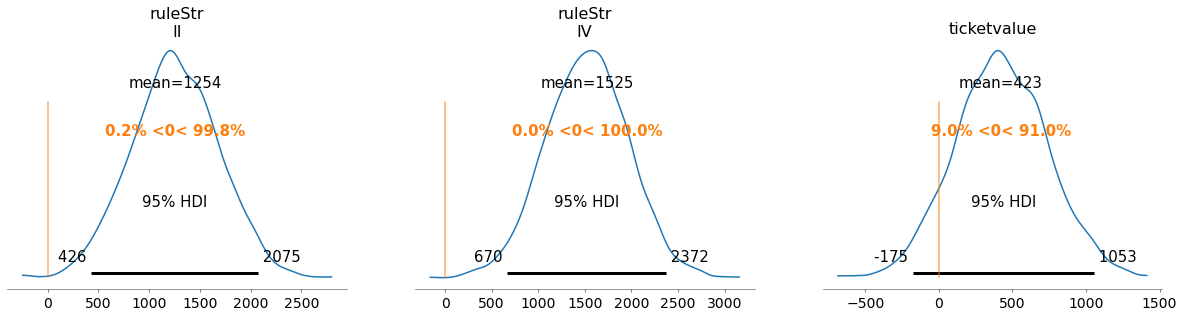

In [54]:
az.plot_posterior(results5rt_test, var_names=["ruleStr","ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
# ------- reaction time
print("Response time in learning phase")

model5rt_learn = bmb.Model('rt ~ ruleStr + ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', learndata5)
results5rt_learn = model5rt_learn.fit(draws=1000, chains=4)
az.summary(results5rt_learn, stat_funcs=func_dict, extend=True)

az.plot_posterior(results5rt_learn, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [33]:
# ------- performance by incentive
model5group = bmb.Model('hitStr["1"] ~ ruleStr*ticketvalue', testdata5, family="bernoulli")
print(model5group)
results5group = model5group.fit(draws=1000, chains=4)
display(az.summary(results5group))


Formula: hitStr["1"] ~ ruleStr*ticketvalue
Family name: Bernoulli
Link: logit
Observations: 10176
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.6284)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3033 5.3844])
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)
    ruleStr:ticketvalue ~ Normal(mu: [0. 0.], sigma: [5.4709 5.5998])


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


                          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                3.171  0.124   2.942    3.404      0.004    0.003   
ruleStr[II]             -1.594  0.141  -1.843   -1.316      0.005    0.003   
ruleStr[IV]             -1.344  0.145  -1.620   -1.077      0.004    0.003   
ticketvalue             -0.154  0.138  -0.426    0.090      0.005    0.003   
ruleStr:ticketvalue[II]  0.315  0.161   0.020    0.626      0.006    0.004   
ruleStr:ticketvalue[IV]  0.286  0.164  -0.014    0.601      0.005    0.004   

                         ess_bulk  ess_tail  r_hat  
Intercept                   959.0    1353.0    1.0  
ruleStr[II]                 976.0    1442.0    1.0  
ruleStr[IV]                1107.0    1643.0    1.0  
ticketvalue                 921.0    1251.0    1.0  
ruleStr:ticketvalue[II]     855.0    1123.0    1.0  
ruleStr:ticketvalue[IV]     987.0    1385.0    1.0  


KeyError: 'p(y, n)_mean'

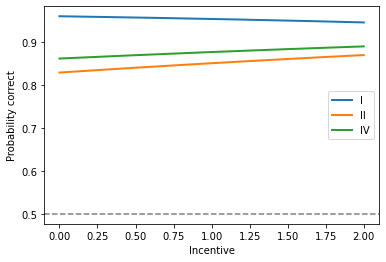

In [34]:

def get_predictions(model, idata, seq, rule):
    # subids = testdata5.query("ruleStr=='"+rule+"'")['subjid'].unique()


    # Create a data frame with the new data
    new_data = pd.DataFrame({"ticketvalue": seq, "ruleStr": rule})

    # Predict probability of dying using out of sample data
    model.predict(idata, data=new_data)

    # Stack chains and draws
    posterior = idata.posterior["hitStr_mean"].stack(samples=("chain", "draw"))
    # Get posterior mean across all draws
    mu = posterior.mean(axis=1)
    return mu

x_seq = np.linspace(0, 2, num=200)
# inverse of the logit function

mu_logit_1 = get_predictions(model5group, results5group, x_seq, "I")
mu_logit_2 = get_predictions(model5group, results5group, x_seq, "II")
mu_logit_4 = get_predictions(model5group, results5group, x_seq, "IV")


plt.plot(x_seq, mu_logit_1, lw=2, label="I")
plt.plot(x_seq, mu_logit_2, lw=2, label="II")
plt.plot(x_seq, mu_logit_4, lw=2, label="IV")
plt.axhline(0.5, c="k", alpha=0.5, ls="--")
plt.xlabel("Incentive")
plt.ylabel("Probability correct")
plt.legend();


In [41]:
# t-tests

bonus_df = df.loc[(df["phase"]=="bonus") & (df["expNum"]==5)]
bonus_df = bonus_df[['subjid', 'game', 'ticketvalue', 'ruleStr', 'testscore','bonus','totalbonustodate']]
bonus_df["percentcorrect"]=bonus_df["testscore"]/8
# display(bonus_df)

df_type1 = bonus_df.loc[df["ruleStr"]=="I"]
df_type2 = bonus_df.loc[df["ruleStr"]=="II"]
df_type4 = bonus_df.loc[df["ruleStr"]=="IV"]


results = pg.ttest(df_type1["testscore"].loc[(df_type1["ticketvalue"]==0.02)], df_type1["testscore"].loc[(df_type1["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,subjid,game,ticketvalue,ruleStr,testscore,bonus,totalbonustodate,percentcorrect
31569,0,0,0.02,I,8.0,0.08,0.08,1.0
31610,0,1,1.23,I,8.0,4.92,5.00,1.0
31651,0,2,1.23,I,8.0,4.92,9.92,1.0
31692,0,3,0.02,I,8.0,0.08,10.00,1.0
31733,2,0,1.23,I,8.0,4.92,4.92,1.0
...,...,...,...,...,...,...,...,...
83516,378,3,0.02,IV,4.0,0.00,1.23,0.5
83557,379,0,0.02,II,8.0,0.08,0.08,1.0
83598,379,1,1.23,II,8.0,4.92,5.00,1.0
83639,379,2,0.02,II,8.0,0.08,5.08,1.0


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.77709,223,less,0.781035,"[-inf, 0.2]",0.056466,0.201,0.006434


In [42]:
results = pg.ttest(df_type2["testscore"].loc[(df_type2["ticketvalue"]==0.02)], df_type2["testscore"].loc[(df_type2["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.692237,211,less,0.046039,"[-inf, -0.0]",0.118714,0.625,0.53113


In [43]:
results = pg.ttest(df_type4["testscore"].loc[(df_type4["ticketvalue"]==0.02)], df_type4["testscore"].loc[(df_type4["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.239347,199,less,0.108338,"[-inf, 0.05]",0.089343,0.336,0.349878


In [46]:
df_test1 = testdata5.loc[df["ruleStr"]=="I"]
df_test2 = testdata5.loc[df["ruleStr"]=="II"]
df_test4 = testdata5.loc[df["ruleStr"]=="IV"]
df_ln1 = learndata5.loc[df["ruleStr"]=="I"]
df_ln2 = learndata5.loc[df["ruleStr"]=="II"]
df_ln4 = learndata5.loc[df["ruleStr"]=="IV"]

print("TESTING PHASE RTs")

results1t = pg.ttest(df_test1["rt"].loc[(df_test1["ticketvalue"]==0.02)], df_test1["rt"].loc[(df_test1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1t)

results2t = pg.ttest(df_test2["rt"].loc[(df_test2["ticketvalue"]==0.02)], df_test2["rt"].loc[(df_test2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2t)

results4t = pg.ttest(df_test4["rt"].loc[(df_test4["ticketvalue"]==0.02)], df_test4["rt"].loc[(df_test4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4t)

print("LEARNING PHASE RTs")

results1l = pg.ttest(df_ln1["rt"].loc[(df_ln1["ticketvalue"]==0.02)], df_ln1["rt"].loc[(df_ln1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1l)

results2l = pg.ttest(df_ln2["rt"].loc[(df_ln2["ticketvalue"]==0.02)], df_ln2["rt"].loc[(df_ln2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2l)

results4l = pg.ttest(df_ln4["rt"].loc[(df_ln4["ticketvalue"]==0.02)], df_ln4["rt"].loc[(df_ln4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4l)

TESTING PHASE RTs


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.311847,1791,less,0.01045,"[-inf, -60.74]",0.067831,0.764,0.889805


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.171543,1695,less,0.120773,"[-inf, 356.55]",0.040064,0.109,0.501762


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.828114,1599,less,0.203865,"[-inf, 446.9]",0.02912,0.079,0.315421


LEARNING PHASE RTs


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.265023,7167,less,0.102952,"[-inf, 137.87]",0.021013,0.059,0.553316


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.514245,6783,less,0.065005,"[-inf, 29.23]",0.025302,0.086,0.669647


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.502912,6399,less,0.066456,"[-inf, 114.17]",0.026516,0.087,0.683029


In [45]:
results = pg.ttest(df_type4["rt"].loc[(df_type4["ticketvalue"]==0.02)], df_type4["rt"].loc[(df_type4["ticketvalue"]==1.23)], paired=True, alternative="less")
results

KeyError: 'rt'

In [23]:
priors = {
    "ruleStr": bmb.Prior("Normal", mu=[0,0,0], sigma=1),
    "ticketvalue": bmb.Prior("Normal", mu=0, sigma=1),
    "ruleStr:ticketvalue": bmb.Prior("Normal", mu=[0,0], sigma=1),
    "1|subjid": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "ticketvalue|subjid": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))
}